In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
df = pd.read_csv("../data/input/train.csv")

# drop bankruptcy_label and company_id in our feature dataset
feature_cols = [col for col in df.columns if col not in ("bankruptcy_label", "company_id")]

X = df[feature_cols].fillna(0)
y = df["bankruptcy_label"]

## Table of content

1. [Methodology](#methodology)
2. [Setting up pipeline](#setting-up-pipeline)
    1. [Feature scaling](#feature-scaling)
    2. [Cross_validation](#cross-validation)
    3. [Resampling](#resampling)
3. [Diagnose the system](#diagnose-the-system)

## Methodology <a id="methodology"></a>


[Goodfellow et al. (2016)](http://www.deeplearningbook.org/contents/guidelines.html) proposes a four-steps methodology for the development of machine learning models. 
As the authors point out, the successful application of machine learning techniques goes beyond the knowledge of algorithms and their principles. To successfully apply machine learning techniques, we need to start with a simple model that we can master and understand. Only then we can determine the next course of action to improve the model.

The recommended four-steps methodology:
1. Select a **performance metric** and a **target value** for this metric. This metric should be driven by the problem that the application is intended to solve. In our case, the goal is to determine which customer the bank could safely lend to. Given the class imbalance issue and the relative importance of recall to precision, we will set our performance metric to be $F_{\beta}$ score, where $\beta=2$. To set the target value for this metric, we would usually look at the current process which this product is trying to replace and use its current metric as the target.      
2. Set up a **working end-to-end pipeline**. This will make sure that we have a solid pipeline that takes care of training the model, evaluating the model using the metric we selected in Step 1 and generating predictions for new, unlabelled dataset.  
3. **Diagnose the system** to determine bottlenecks in performance. We will utilize techniques such as learning curve and validation curve to understand the behavior of the system, in particular if it is underfitting, overfitting, or if it has any data/software defects.
4. Improve the system by repeatedly **making incremental changes**. There are many ways to improve the system. For example, we can gather new data, apply feature engineering, tune hyperparameters, or change the machine learning algorithm. It all depends on the diagnosis report in Step 3.

We have already gone through step 1 in the first notebook. We will focus on step 2 and 3 in this notebook. We will leave step 4 to the next notebook. 

## Setting up pipeline <a id="setting-up-pipeline"></a>


Following this methodology, our initial goal is to develop a model that we can use as a baseline. This model will be our **Minimum Viable Model (MVM)**. Note that, right now, it doesn't matter how well the model performs. We just need an end-to-end pipeline. 

The pipeline should perform the following steps:

1. Split the data into training, validation, and test sets.
2. Use the training and validation set to tune the model.
3. Report the metric on test set. *Note that this should only be used for reporting purposes. If we use the performance on the test set to tune the model, then this wouldn't give us a good estimate of the generalization error.*
4. Train on the entire dataset and generate predictions for new, unlabelled dataset. 

We will skip steps 3 and 4 here since we want to focus on diagnosing and tuning the model in this notebook. 

### Feature scaling <a id="feature-scaling"></a>

For our MVM, let's start with a simple model: logistic regression. From our exploratory data analysis, we know that the features have very different scales so we will need to perform feature scaling before training the model. This is because many machine learning algorithms (especially gradient-based algorithms) are designed with the assumption that all features vary on comparable scales. A notable exception are decision tree-based algorithms that are robust to arbitrary scaling of the data. 

There are multiple feature scaling methods we could use and we could broadly categorize them into *linear* (StandardScaler, MinMaxScaler) vs *non-linear* transformations (QuantileTransformer, PowerTransformer). Normally, I wouldn't delve too deeply into this but given that we have outliers in our dataset, we would need to be more careful. If our data contains many **outliers**, scaling using the **mean and variance** of the data is likely to **not work very well**. For this reason, I will use the RobustScaler since it scales the data according to the median and the interquartile range, which are more robust to outliers. 

To learn more about the effect of different scalers on data with outliers, I recommend reading this [sklearn example](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py).

### Cross-validation <a id="cross-validation"></a>

Since we have a class imbalance issue, we also have to be extra careful in splitting the dataset into train, validation and test set.

In particular, it is recommended to use **stratified sampling** to **preserve relative class frequencies** in each train, validation and test fold. To recap, the proportion of positive class in our dataset is approximately 5% (515 out of 9792 samples). 

We will do a 80/20 split for first level train/test split, and then apply a 3-fold cross validation. 

Therefore, we should have 412 positive class samples (515 * 80%) in our training set and 103 (515 * 20%) in our test set.

For our 3-fold cross validation, we should have 137 positive class samples (412 / 3) in each validation fold. Since there is a remainder of 1, we will just assign this extra positive sample in the last fold.

In [3]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate

# first level train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

print(f"Positive class samples in train set: {np.bincount(y_train)[1]}")
print(f"Positive class samples in test set: {np.bincount(y_test)[1]} \n")

# 3-fold cross validation
stratified_cv = StratifiedKFold(n_splits=3)
for (train, validation) , sequence in zip(stratified_cv.split(X_train, y_train), ("first", "second", "third")):
    print(f"Positive class samples in {sequence} validation fold: {np.bincount(y_train.iloc[validation])[1]}")


Positive class samples in train set: 412
Positive class samples in test set: 103 

Positive class samples in first validation fold: 137
Positive class samples in second validation fold: 137
Positive class samples in third validation fold: 138


### Imbalanced classification 

Imbalanced classification is a huge challenge for predictive modeling because it might result in models that **favor the majority class** and hence have **poor predictive performance on the minority class**. This is a problem because in our case, the minority class (bankrupt companies) is more important.  

The minority class is harder to predict because there are few examples of this class, by definition. This means it is more challenging for a model to learn the characteristics of examples from this class, and to differentiate examples from this class from the majority class. A naive application of the model may focus on learning the characteristics of the abundant observations only, neglecting the examples from the minority class.

There are different ways to deal with this problem:
1. **Resampling** the dataset 
2. Different **algorithms** (e.g decision trees)
3. **Penalized models** (impose an additional cost on the model for making classification mistakes on the minority class)
4. Different **approaches** (e.g anomaly detection/change detection)

We will start with resampling the dataset as it's the easiest to implement using [imbalanced-learn](https://imbalanced-learn.readthedocs.io/en/stable/introduction.html) package, which is compatible with Python's scikit-learn interface.


#### Reference

- [Tactics-to-combat-imbalanced-classes](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)
- [Oversampling and undersampling in data analysis](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis)

### Resampling <a id="resampling"></a> 

Broadly speaking, there are two ways to resample the data:

1. **Oversampling** (add copies of instances from the minority class)
    - Random oversampling
    - Synthetic Minority Over-sampling Technique (SMOTE)
    - Adaptive Synthetic (ADASYN)
    
    
2. **Undersampling** (delete instances from the majority class)
    - Random undersampling
    - Prototype generation (Cluster) 
    - Prototype selection (Controlled vs Cleaning under-sampling)
    
We will start with the simplest resampling strategies: **random oversampling** and **random undersampling**.

The only hyperparameter we can tune is *sampling_strategy*.
- For oversampling, it corresponds to the ratio of *minority class* samples to *majority class samples* after resampling. 
- For undersampling, it corresponds to the ratio of *majority class* samples to *minority class samples* after resampling. 

The default ratio is 1 (i.e. perfectly balanced dataset).

We should only resample our training set, not the test set. In order to perform this correctly in our 3-fold cross validation, we will use the *imblearn Pipeline object*, which will ensure the **samplers are only applied during fit, not predict**.

In [4]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

print(f"Before resampling: \n{y_train.value_counts()}")

ros = RandomOverSampler(random_state=0)
X_ros, y_ros = ros.fit_resample(X_train, y_train)
print(f"\nAfter oversampling: \n{y_ros.value_counts()}")

rus = RandomUnderSampler(random_state=0)
X_rus, y_rus = rus.fit_resample(X_train, y_train)
print(f"\nAfter undersampling: \n{y_rus.value_counts()}")

Before resampling: 
0    7421
1     412
Name: bankruptcy_label, dtype: int64

After oversampling: 
1    7421
0    7421
Name: bankruptcy_label, dtype: int64

After undersampling: 
1    412
0    412
Name: bankruptcy_label, dtype: int64


### Putting it all together 

*Note: Although we have selected F-beta score as our metric, we will also output precision and recall for the purpose of diagnosing the model and understanding the bottlenecks in performance.*

In [5]:
from sklearn.metrics import fbeta_score, make_scorer
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression

def evaluate_pipeline(pipeline, X_train, y_train, cv):
    """
    Run cross validation for the input pipeline and returns the average precision, recall and F-beta score.
    """
    cv_metrics = cross_validate(pipeline, X_train, y_train, cv=cv, scoring={"precision":"precision", "recall":"recall", "fbeta":make_scorer(fbeta_score, beta=2)})
    cv_metrics_df = pd.DataFrame(cv_metrics)
    average_cv_metrics = cv_metrics_df[["test_precision", "test_recall", "test_fbeta"]].mean()
    return average_cv_metrics

scaler = RobustScaler()
classifier = LogisticRegression(random_state=0, solver='newton-cg', max_iter=200)

# oversampling
oversampling_pipeline = Pipeline([('ros', ros), ('scaler', scaler), ("classifier", classifier)])
oversampling_metrics = evaluate_pipeline(oversampling_pipeline, X_train, y_train, stratified_cv)
print(f"Metrics with random oversampling: \n{oversampling_metrics}\n")

# undersampling
undersampling_pipeline = Pipeline([('rus', rus), ('scaler', scaler), ("classifier", classifier)])
undersampling_metrics = evaluate_pipeline(undersampling_pipeline, X_train, y_train, stratified_cv)
print(f"Metrics with random undersampling: \n{undersampling_metrics}")

Metrics with random oversampling: 
test_precision   0.12
test_recall      0.65
test_fbeta       0.35
dtype: float64

Metrics with random undersampling: 
test_precision   0.12
test_recall      0.68
test_fbeta       0.36
dtype: float64


##### Results:

We observe that random undersampling gives us a better recall but the precision for both methods are low.

In layman terms, if the model predicts that 100 companies will default, in reality only 12 of them actually defaults.  

From a practical point of view, if undersampling and oversampling give us more or less the same result, I would prefer undersampling since it makes training the model much faster. Recall that when we use undersampling, we are only using 412 training examples (as opposed to 7421 training examples with oversampling). That's nearly 18x reduction in the dataset size! 

You might not notice the difference in training time here but in real-life machine learning, you might have thousands/millions of training examples, which will make a huge difference.

## Diagnose the system <a id="diagnose-the-system"></a>


> A good machine learning practitioner needs to know how to monitor and respond to feedback obtained from experiments in order to improve a machine learning system. 

During day-to-day development of machine learning systems, practitioners need to decide whether to 
- gather more training data
- perform feature engineering 
- apply feature selection
- tune hyperparameters
- change the machine learning algorithm 

All these operations are at the very least time consuming to try out, so it is important to be able to determine the right course of action rather than blindly guessing.

We will use [learning curves](https://scikit-learn.org/stable/modules/learning_curve.html#learning-curve) to diagnose our system.

### Learning curve 

A learning curve shows the **training and validation score** of the pipeline for **increasing number of training samples**. It is a tool to find out how much we benefit from adding more training data and whether the pipeline suffers from a high variance or a high bias issue. This allows us to diagnose if the model is **overfitting** or **underfitting**.

**Overfitting** 
 * The pipeline performs well on the training set, but not on the validation set. In other words, the pipeline is not able to generalize to unseen data.
 * The learning curve will present a gap between the training and validation scores. 
 * Adding more training samples will most likely increase generalization.
 * We should try to **reduce model complexity** by
     * Apply feature selection to select smaller sets of features 
     * Increase regularization 


**Underfitting**
 * The pipeline is not able to perform well in either training or validations sets. 
 * The learning curve will converge to a low score. 
 * Gathering more data is not helpful because the learning curve has already converged. 
 * We should try to **increase model complexity** by 
     * Perform feature engineering (e.g collect a different set of features or add polynomial/interaction terms)
     * Reduce regularization 

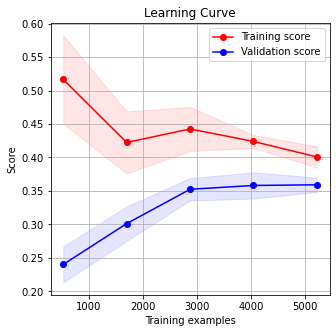

In [6]:
from diagnosis import plot_learning_curve

# since this will is a 2D plot, we will only plot a metric (F-beta score) on the y-axis
plot_learning_curve(undersampling_pipeline, X_train, y_train, stratified_cv, make_scorer(fbeta_score, beta=2))

##### Results:

The learning curve converges to a low score so the model is underfitting. 

A quick thing we can try here is to reduce regularization by increasing the hyperparameter *C*, where bigger values indicate less regularization. 

The default is set to 1. We will try values in logarithmic scale, which enables us to search a bigger space quickly.

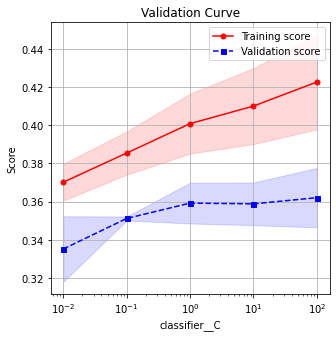

In [7]:
from diagnosis import plot_validation_curve

param_name="classifier__C"
param_range=[0.01, 0.1, 1, 10, 100]

plot_validation_curve(undersampling_pipeline, X_train, y_train, stratified_cv, make_scorer(fbeta_score, beta=2), param_name, param_range, log_scale=True)

##### Results:

It seems like increasing the hyperparameter C (i.e. reducing regularization) leads to an increase in the training score but not the validation score.

This suggests that the hyperparameter C is already optimal. We should therefore try feature engineering, which we would continue in the next notebook.